In [24]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
from matplotlib import rcParams
from statsmodels.tsa import tsatools
from dmba import regressionSummary
from matplotlib.patches import Ellipse
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
daily_peak_df=pd.read_excel('Data/niti/Daily_Peak_Demand7.xlsx',skipfooter=4)

daily_peak_df['Date']=pd.to_datetime(daily_peak_df['Date'],format='%d-%m-%Y')
daily_peak_ts=pd.Series(daily_peak_df['Peak Demand Met'].values,index=daily_peak_df['Date'],name='Daily_Peak')
daily_peak_ts.index=pd.DatetimeIndex(daily_peak_ts.index,freq='d')
daily_peak_df.dropna(inplace=True)
daily_peak_ts.dropna(inplace=True)

In [17]:
ax=daily_peak_ts.plot()
ax.set

<bound method Axes.set of <Axes: title={'center': 'Daily Peak Demand Met\n20 Apr 17 to 06 Nov 23'}, xlabel='Date', ylabel='Electricity Consumption (MW)'>>

In [4]:
daily_peak_ts.values

array([158628., 155542., 152714., ..., 201946., 192944., 198571.])

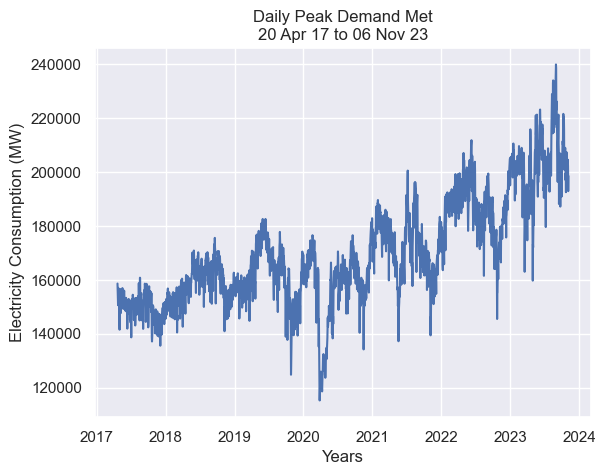

In [23]:
sns.set(style="darkgrid")
sns.lineplot(x=daily_peak_ts.index, y=daily_peak_ts.values, data=daily_peak_ts)
plt.xlabel("Years")
plt.ylabel("Electricity Consumption (MW)")
plt.title("Daily Peak Demand Met\n20 Apr 17 to 06 Nov 23")
plt.savefig('Data/images/Daily Peak.png',dpi=400,bbox_inches='tight')
plt.show()


/var/folders/nh/46bvkkfx38z0t75cg6clp_c00000gn/T/ipykernel_75445/672272239.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


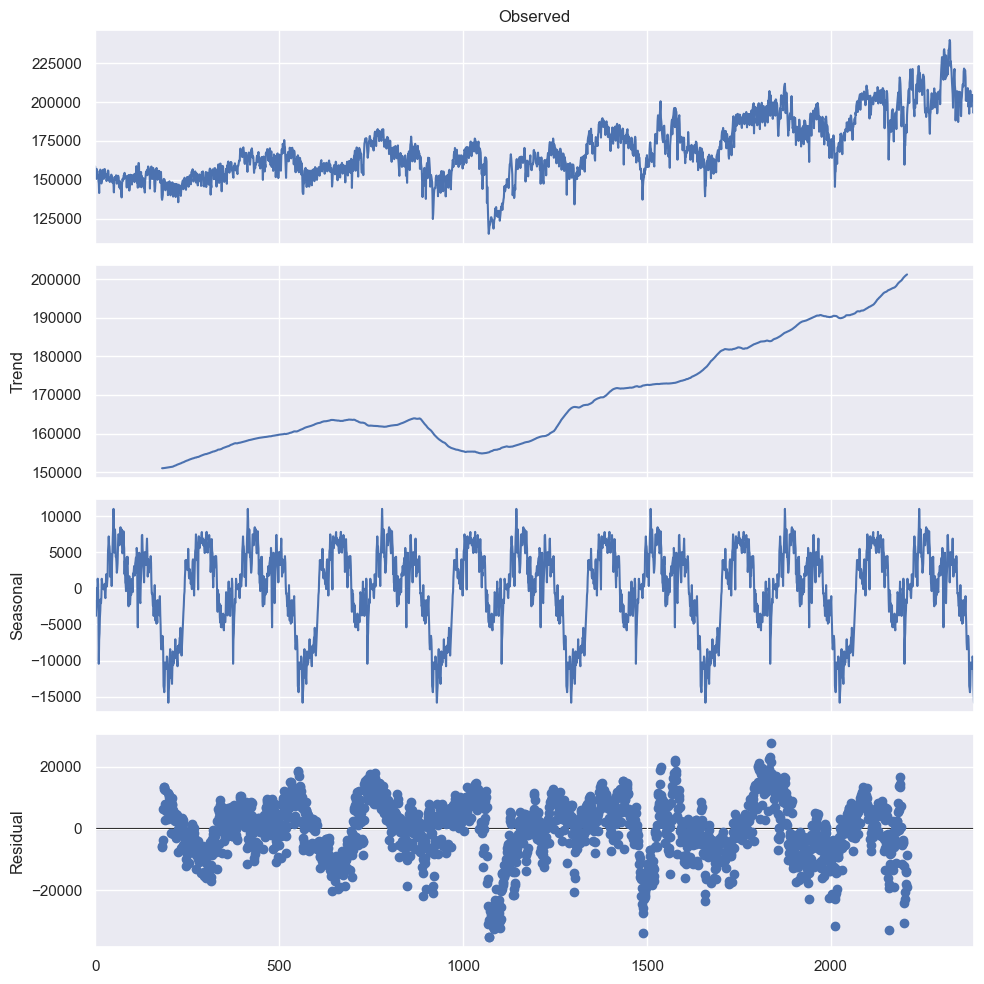

In [85]:
# Perform seasonal decomposition
result = seasonal_decompose(daily_peak_ts.values, model='additive', period=365)  # 'additive' or 'multiplicative'
# Fit a linear regression line to the trend component



plt.rcParams.update({'figure.figsize': (10,10)})
fig=result.plot()
# fig.axes[0].set_ylabel('Observed') # Label 1st subplot's y-axis.
# plt.xlabel('Year') 
plt.tight_layout()


# x_values = np.arange(len(result.trend))
# slope, intercept = np.polyfit(x_values, result.trend, 1)
# linear_fit = slope * x_values + intercept

# # Plot the original time series and the decomposed components
# plt.figure(figsize=(12, 8))


# plt.subplot(4, 1, 1)
# plt.plot(daily_peak_ts.values, label='Original Time Series')
# plt.ylabel('Orioginal Series')

# plt.subplot(4, 1, 2)
# lines,=plt.plot(result.trend, label='Trend')
# # plt.plot( linear_fit, label='Linear Fit', linestyle='--', color='red')
# plt.ylabel('Trend')
# xData=lines.get_ydata()

# plt.subplot(4, 1, 3)
# plt.plot(result.seasonal, label='Seasonality')
# plt.ylabel('Seasonality')

# plt.subplot(4, 1, 4)
# plt.plot(result.resid, label='Residuals')
# plt.ylabel('Residuals')

# # plt.tight_layout()
# plt.suptitle('Time series decomposition with yearly seasonality')



# plt.show()

In [89]:
not_nan_mask = ~np.isnan(result.trend)
trend_values = result.trend[not_nan_mask]

In [90]:
trend_values

array([151001.02739726, 150989.9890411 , 151001.10684932, ...,
       201134.98356164, 201189.17534247, 201273.02191781])

Text(0.5, 1.0, 'Plot of electricity consumption')

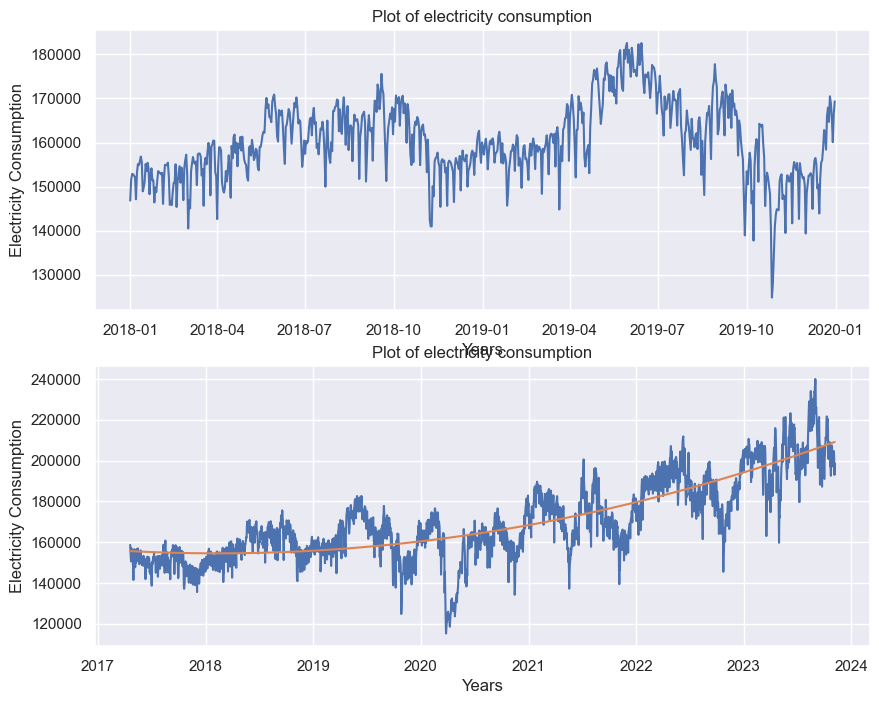

In [22]:
# # create short time series from 1997 to 1999 using a slice
daily_peak_ts_3yrs = daily_peak_ts['2018':'2019']
# # create a data frame with additional predictors from time series
# # the following command adds a constant term, a trend term and a quadratic trend term
daily_peak_df = tsatools.add_trend(daily_peak_ts, trend='ctt')
# # fit a linear regression model to the time series
X = sm.add_constant(daily_peak_df[['const','trend', 'trend_squared']])
daily_peak_lm = sm.OLS(daily_peak_df['Daily_Peak'],X).fit()

# # shorter and longer time series
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
# daily_peak_ts_3yrs.plot(ax=axes[0])
# daily_peak_ts.plot(ax=axes[1])
# for ax in axes:
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Ridership (in 000s)')
# #     ax.set_ylim(1300, 2300)
# daily_peak_lm.predict(X).plot(ax=axes[1])
# plt.show()

sns.set(style="darkgrid")

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

sns.lineplot(x=daily_peak_ts_3yrs.index, y=daily_peak_ts_3yrs.values, data=daily_peak_ts_3yrs,ax=axes[0])
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Electricity Consumption")
axes[0].set_title("Plot of electricity consumption")


sns.lineplot(x=daily_peak_ts.index, y=daily_peak_ts.values, data=daily_peak_ts,ax=axes[1])
sns.lineplot(x=daily_peak_lm.predict(X).index, y=daily_peak_lm.predict(X).values)
axes[1].set_xlabel("Years")
axes[1].set_ylabel("Electricity Consumption")
axes[1].set_title("Plot of electricity consumption")



In [7]:
# Data Partitioning and performance evaluation
daily_peak_ts_valid = daily_peak_ts['2022':'2024']
nValid = len(daily_peak_ts_valid)
nTrain = len(daily_peak_ts) - nValid
# partition the data
train_ts = daily_peak_ts[:nTrain]
valid_ts = daily_peak_ts[nTrain:]
naive_pred = pd.Series(train_ts[-1], index=valid_ts.index)
last_season=train_ts[-365:]
seasonal_pred = pd.Series(pd.concat([last_season]*5)[:len(valid_ts)].values,
                          index=valid_ts.index)

In [8]:
# plot forecasts and actual in the training and validation sets
ax = train_ts.plot(color='C0', linewidth=0.75, figsize=(9,7))
valid_ts.plot(ax=ax, color='C0', linestyle='dashed', linewidth=0.75)
# ax.set_xlim('1990', '2006-6')
# ax.set_ylim(1300, 2600)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
naive_pred.plot(ax=ax, color='green')
seasonal_pred.plot(ax=ax, color='orange')


<Axes: title={'center': 'Plot of electricity consumption'}, xlabel='Date', ylabel='Ridership (in 000s)'>

In [9]:
regressionSummary(valid_ts, naive_pred)
regressionSummary(valid_ts, seasonal_pred)


Regression statistics

                      Mean Error (ME) : 13428.9052
       Root Mean Squared Error (RMSE) : 19405.1805
            Mean Absolute Error (MAE) : 15782.4163
          Mean Percentage Error (MPE) : 6.4056
Mean Absolute Percentage Error (MAPE) : 7.8084

Regression statistics

                      Mean Error (ME) : 21558.6474
       Root Mean Squared Error (RMSE) : 27438.0467
            Mean Absolute Error (MAE) : 22800.0104
          Mean Percentage Error (MPE) : 10.6296
Mean Absolute Percentage Error (MAPE) : 11.3496


# Regression-Based Forecasting

In [10]:
import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.api as sm
from statsmodels.tsa import tsatools, stattools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots


# Linear Trend

In [11]:
daily_peak_df=pd.read_excel('Data/niti/Daily_Peak_Demand7.xlsx',skipfooter=4)

daily_peak_df['Date']=pd.to_datetime(daily_peak_df['Date'],format='%d-%m-%Y')
daily_peak_ts=pd.Series(daily_peak_df['Peak Demand Met'].values,index=daily_peak_df['Date'],name='Daily_Peak')
daily_peak_ts.index=pd.DatetimeIndex(daily_peak_ts.index,freq='d')
daily_peak_df.dropna(inplace=True)
daily_peak_ts.dropna(inplace=True)

# # create a data frame with additional predictors from time series
# # the following command adds a constant term, a trend term and a quadratic trend term
daily_peak_df = tsatools.add_trend(daily_peak_ts, trend='ct')
# # fit a linear regression model to the time series
X = sm.add_constant(daily_peak_df[['const','trend']])
daily_peak_lm = sm.OLS(daily_peak_df['Daily_Peak'],X).fit()

# shorter and longer time series
ax = daily_peak_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
daily_peak_lm.predict(X).plot(ax=ax)
plt.show()

/var/folders/nh/46bvkkfx38z0t75cg6clp_c00000gn/T/ipykernel_75445/1709517712.py:21: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [12]:
ridership_df

NameError: name 'ridership_df' is not defined

In [ ]:
# load data and convert to time series
Amtrak_df = pd.read_csv('D:EPABA/Python/book/dmba/Amtrak.csv')
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date,name='Ridership')
# fit a linear trend model to the time series
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
X = sm.add_constant(ridership_df[['const','trend']])
# ridership_lm = sm.ols(formula='Ridership ~ trend', data=ridership_df).fit()
ridership_lm = sm.OLS(ridership_df['Ridership'],X).fit()

# shorter and longer time series
ax = ridership_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ridership_lm.predict(X).plot(ax=ax)
plt.show()

In [ ]:
ridership_df

In [ ]:
nValid = 36
nTrain = len(ridership_ts) - nValid
# partition the data
train_ts = ridership_ts[:nTrain]
valid_ts = ridership_ts[nTrain:]
naive_pred = pd.Series(train_ts[-1], index=valid_ts.index)
last_season = train_ts[-12:]
seasonal_pred = pd.Series(pd.concat([last_season]*5)[:len(valid_ts)].values,
                          index=valid_ts.index)

In [ ]:
train_ts

In [ ]:
valid_ts

In [ ]:
last_season

In [ ]:
ridership_ts

In [ ]:
pd.concat([last_season]*5)[:len(valid_ts)]

In [ ]:
daily_peak_ts_3yrs

In [ ]:
daily_peak_ts